# Finite Differencing for simplified 1d NS equation

Making a few assumptions, the equation takes the following form
$\frac{\partial u}{\partial t} + u \frac{\partial u }{\partial x} = -\frac{1}{\rho} \frac{\partial P}{\partial x} + \frac{\mu}{\rho}\frac{\partial^2 u}{\partial x^2}~,$

To solve the above equation, we use method of line for integration in time, and finite differencing for integration in space. 


Assuming uniform pressure, and 0 viscosity, we first solve the inviscid Burgers' equation

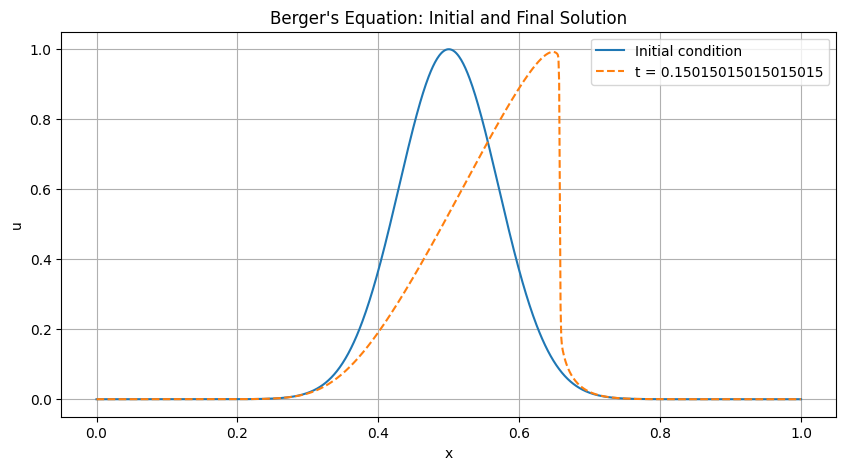

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def initialize(nx, L):
    """ Initialize the domain and initial condition. """
    dx = L / (nx - 1)
    x = np.linspace(0, L, nx)
    u_initial = np.exp(-100 * (x - 0.5 * L) ** 2)
    return x, u_initial, dx

def apply_boundary_conditions(u):
    """ Apply boundary conditions (periodic in this case). """
    u_new = np.copy(u)
    u_new[0] = u[-2]
    u_new[-1] = u[1]
    return u_new

def cal_rhs(u, dx):
    """ Calculate rhs using the second-order upwind scheme. """
    rhs = np.zeros_like(u)
    rhs[u>=0] = - (u * (u - np.roll(u,+1)))[u>=0]/dx
    rhs[u<0] = - (u * (np.roll(u,-1)) - u)[u<0]/dx
    return rhs

def time_steping(u, dx, dt):
    """ First order integration in time """
    u_new = np.zeros_like(u)
    u_new = u + dt * cal_rhs(u,dx)

    u_new = apply_boundary_conditions(u_new)
    return u_new

def run_simulation(nx, L, cfl, nt):
    """ Run the advection simulation and return results. """
    x, u_initial, dx = initialize(nx, L)
    dt = cfl*dx
    tlim = dt * nt
    u = u_initial.copy()
    
    # Time-stepping loop
    for _ in range(nt):
        u = time_steping(u, dx, dt)
    
    return x, u_initial, u, tlim

def plot_results(x, u_initial, u, tlim):
    """ Plot the initial and final solutions. """
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u, label='t = %s'%tlim, linestyle='--')
    plt.title('Berger\'s Equation: Initial and Final Solution')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
nt = 300            # Number of time steps
c = 1

# CFL condition
dx = L / (nx - 1)
cfl = 0.5
assert cfl <= 1, "CFL condition violated, reduce time step or increase spatial resolution."

# Run the simulation
x, u_initial, u_final, tlim = run_simulation(nx, L, cfl, nt)

# Plot the results
plot_results(x, u_initial, u_final, tlim)


# Now add the dissipation (viscosity) term

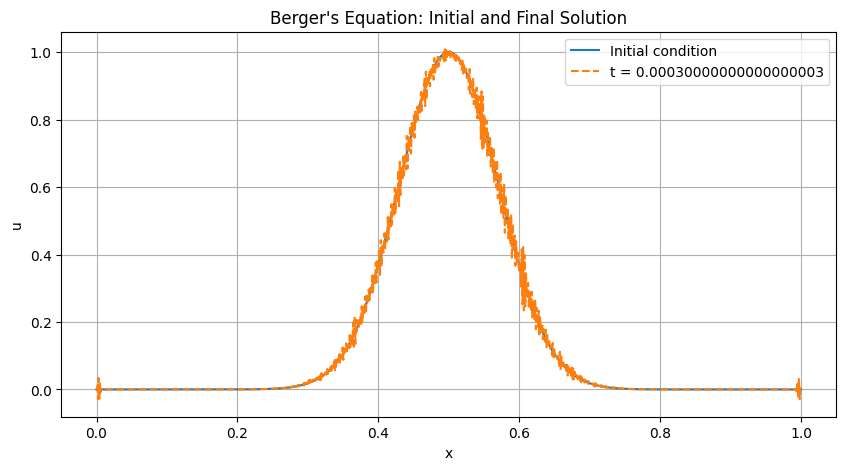

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def initialize(nx, L):
    """ Initialize the domain and initial condition. """
    dx = L / (nx - 1)
    x = np.linspace(0, L, nx)
    u_initial = np.exp(-100 * (x - 0.5 * L) ** 2)
    return x, u_initial, dx

def apply_boundary_conditions(u):
    """ Apply boundary conditions (periodic in this case). """
    u[0] = u[-2]
    u[-1] = u[1]
    return u

def compute_second_derivative(u, dx):
    """ Compute the second derivative of u using a three-point stencil. """
    u_xx = np.zeros_like(u)
    u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    u_xx = apply_boundary_conditions(u_xx)
    return u_xx

def cal_rhs(u, dx, nu):
    """ Calculate rhs using the second-order upwind scheme. """
    rhs = np.zeros_like(u)
    rhs = - 0.5 * (u * (np.roll(u,-1) - np.roll(u, +1))) / dx

    #rhs[u >= 0] = - (u * (u - np.roll(u, +1)))[u >= 0] / dx
    #rhs[u < 0] = - (u * (u - np.roll(u, +1)))[u < 0] / dx
    
    # Add viscosity term
    rhs += nu * compute_second_derivative(u, dx)
    
    rhs = apply_boundary_conditions(rhs)
    return rhs

def rk4_step(u, dx, dt, nu):
    """ Perform one time step using RK4 integration method. """
    # Stage 1
    k1 = dt * cal_rhs(u, dx, nu)
    
    # Stage 2
    u_k2 = u + 0.5 * k1
    k2 = dt * cal_rhs(u_k2, dx, nu)
    
    # Stage 3
    u_k3 = u + 0.5 * k2
    k3 = dt * cal_rhs(u_k3, dx, nu)
    
    # Stage 4
    u_k4 = u + k3
    k4 = dt * cal_rhs(u_k4, dx, nu)
    
    # Combine stages
    u_next = u + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    u_next = apply_boundary_conditions(u_next)
    return u_next

def run_simulation(nx, L, nu, dt, nt):
    """ Run the advection simulation and return results. """
    x, u_initial, dx = initialize(nx, L)
    u = u_initial.copy()
    
    for _ in range(nt):
        u = rk4_step(u, dx, dt, nu)  
    
    return x, u_initial, u

def plot_results(x, u_initial, u, tlim):
    """ Plot the initial and final solutions. """
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u, label='t = %s'%tlim, linestyle='--')
    plt.title('Berger\'s Equation: Initial and Final Solution')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
dt = 0.0001           # Time step size
nt = 3              # Number of time steps
tlim = dt * nt      # End time for simulation
nu = 0.1            # Viscosity

# Initialize
dx = L / (nx - 1)
x, u_initial, u_final = run_simulation(nx, L, nu, dt, nt)

# Plot the results
plot_results(x, u_initial, u_final, tlim)

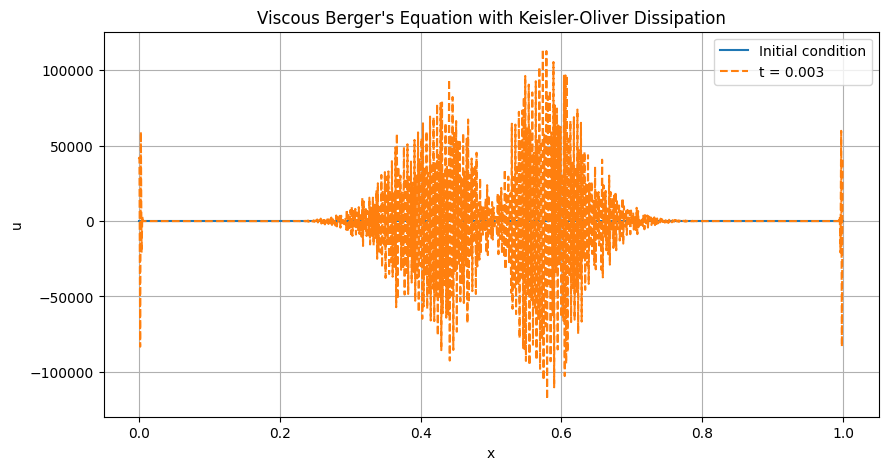

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def initialize(nx, L):
    """ Initialize the domain and initial condition. """
    dx = L / (nx - 1)
    x = np.linspace(0, L, nx)
    u_initial = np.exp(-100 * (x - 0.5 * L) ** 2)
    return x, u_initial, dx

def apply_boundary_conditions(u):
    """ Apply periodic boundary conditions. """
    u[0] = u[-2]
    u[-1] = u[1]
    return u

def compute_second_derivative(u, dx):
    """ Compute the second derivative of u using central differencing. """
    u_xx = np.zeros_like(u)
    u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    u_xx = apply_boundary_conditions(u_xx)
    return u_xx

def keisler_oliver_dissipation(u, dx):
    """ Compute Keisler-Oliver dissipation term. """
    dissipation = np.zeros_like(u)
    # First-order dissipation term
    dissipation[1:-1] += (u[2:] - u[1:-1]) / dx
    dissipation[1:-1] -= (u[1:-1] - u[:-2]) / dx
    dissipation[1:-1] *= -1
    # Second-order dissipation term
    dissipation[1:-1] += (u[2:] - 2 * u[1:-1] + u[:-2]) / (dx**2)
    dissipation = apply_boundary_conditions(dissipation)
    return dissipation

def cal_rhs(u, dx, nu):
    """ Calculate the right-hand side with dissipation. """
    rhs = np.zeros_like(u)
    rhs[1:-1] = -u[1:-1] * (u[2:] - u[:-2]) / (2 * dx)
    rhs[1:-1] += nu * compute_second_derivative(u, dx)[1:-1]
    rhs[1:-1] += keisler_oliver_dissipation(u, dx)[1:-1]
    rhs = apply_boundary_conditions(rhs)
    return rhs

def rk2_step(u, dx, dt, nu):
    """ Perform one time step using RK2 integration method. """
    # Stage 1
    k1 = dt * cal_rhs(u, dx, nu)
    u_star = u + k1
    
    # Stage 2
    k2 = dt * cal_rhs(u_star, dx, nu)
    u_next = u + 0.5 * (k1 + k2)
    
    u_next = apply_boundary_conditions(u_next)
    return u_next

def run_simulation(nx, L, nu, dt, nt):
    """ Run the Berger's equation simulation and return results. """
    x, u_initial, dx = initialize(nx, L)
    u = u_initial.copy()
    
    # Time-stepping loop
    for _ in range(nt):
        u = rk2_step(u, dx, dt, nu)
    
    return x, u_initial, u

def plot_results(x, u_initial, u, tlim):
    """ Plot the initial and final solutions. """
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u, label=f't = {tlim}', linestyle='--')
    plt.title('Viscous Berger\'s Equation with Keisler-Oliver Dissipation')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
dt = 0.001           # Time step size
nt = 3              # Number of time steps
tlim = dt * nt      # End time for simulation
nu = 0.1            # Viscosity

# Initialize
dx = L / (nx - 1)
x, u_initial, u_final = run_simulation(nx, L, nu, dt, nt)

# Plot the results
plot_results(x, u_initial, u_final, tlim)